# Сборный Проект — 1

## Цель проекта

Задачей проекта является выявление закономерностей, определяющих успешность игры. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Были доступны данные до 2016 года, на основе которых необходимо спланировать рекламную кампанию на 2017 год.

## Шаг 1. Открыли файл с данными и изучили общую информацию

In [1]:
# загрузили необходимые библиотеки
import pandas as pd
from scipy import stats as st
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
from matplotlib.ticker import FormatStrFormatter

In [2]:
# загрузили данные из файла в датафрейм
data = pd.read_csv('/datasets/games.csv', sep=',')  

In [3]:
#  посмотрели первые 5 
pd.set_option('display.max_columns', 50)
display(data.head())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
# вывели основную информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


# Шаг 2. Подготовили данные

###  Замена названий столбцов

In [5]:
# Заменили названия столбцов (привели к нижнему регистру)
data = data.rename(columns = {'Name':'name', 'Platform':'platform', 'Year_of_Release':'year_of_release',
                              'Genre':'genre','NA_sales':'na_sales','EU_sales':'eu_sales',
                              'JP_sales':'jp_sales','Other_sales':'other_sales',
                              'Critic_Score':'critic_score','User_Score':'user_score','Rating':'rating'})

In [6]:
# определили в каких столбцах есть пропуски
data.isna().sum() 



name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

### Обработаем все пропуски 

In [7]:
# определили процент пропусков в столбцах
(
    (data.isna().mean()*100)
    .sort_values(ascending=False)
    .to_frame()
    .rename(columns = {0:'percent_space'})
    .style.background_gradient('coolwarm').format("{:.1f}")
)

,percent_space
critic_score,51.3
rating,40.5
user_score,40.1
year_of_release,1.6
name,0.0
genre,0.0
platform,0.0
na_sales,0.0
eu_sales,0.0
jp_sales,0.0


In [8]:
# посчитаем количество строк в в выборке до обработки и удаление выбросов
row_number_before = data.shape[0] 
display(row_number_before)


16715

Как мы видим в 6 столбцах из 11 у нас отсутствуют данные. Проанализируем пропуски и заполним где это возможно. 

In [9]:
# посмотрим строки в которых нет данных в колонке с Наименованием игры
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Как мы видим в двух строках с пропущенными наименованиями игр так же отсутствуют данные о жанре, оценке критиков и пользователей и рейтинге. Поэтому целесообразно удалить эти 2 строки.

In [10]:
# удалим строки с пропущенными именами игр
data = data.dropna(subset = ['name'])

In [11]:
# проверим наличие дубликатов.

print(data.loc[data.duplicated(subset=['name','year_of_release','platform'])]) 

                name platform  year_of_release   genre  na_sales  eu_sales  \
16230  Madden NFL 13      PS3           2012.0  Sports       0.0      0.01   

       jp_sales  other_sales  critic_score user_score rating  
16230       0.0          0.0          83.0        5.5      E  


In [12]:
# посмотрим все строки с данным именем, чтобы убедиться в явном дублировании
data[data['name']=='Madden NFL 13']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
507,Madden NFL 13,X360,2012.0,Sports,2.53,0.15,0.0,0.17,81.0,5.8,E
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
3986,Madden NFL 13,Wii,2012.0,Sports,0.47,0.00,0.0,0.03,NaN,7.3,E
5887,Madden NFL 13,PSV,2012.0,Sports,0.28,0.00,0.0,0.02,63.0,7.3,E
7066,Madden NFL 13,WiiU,2012.0,Sports,0.21,0.00,0.0,0.02,75.0,6.7,E
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


** Как мы видим строки 604 и 16230 являются дубликатами, но в строке 16230 даные только по Европейским продажам, логично добавить 0.01 в продажи по строкам 604.

In [13]:
# удалим строку 16230 - явный дубликат

data = data.drop(index=[16230], axis=0)


In [14]:
# добавим 0.01 по столбцу eu_sales в 604 строку, присвоив новое значение - 0,23

data.loc[data.index == 604, 'eu_sales'] = 0.23



In [15]:
# для работы с неявными дубликатами проверим все имена
for game in sorted(data['name'].unique()):
    print(game)

 Beyblade Burst
 Fire Emblem Fates
 Frozen: Olaf's Quest
 Haikyu!! Cross Team Match!
 Tales of Xillia 2
'98 Koshien
.hack//G.U. Vol.1//Rebirth
.hack//G.U. Vol.2//Reminisce
.hack//G.U. Vol.2//Reminisce (jp sales)
.hack//G.U. Vol.3//Redemption
.hack//Infection Part 1
.hack//Link
.hack//Mutation Part 2
.hack//Outbreak Part 3
.hack//Quarantine Part 4: The Final Chapter
.hack: Sekai no Mukou ni + Versus
007 Racing
007: Quantum of Solace
007: The World is not Enough
007: Tomorrow Never Dies
1 vs. 100
1/2 Summer +
10 Minute Solution
100 All-Time Favorites
100 Classic Books
100 Classic Games
1000 Cooking Recipes from ELLE à table
1001 Touch Games
101-in-1 Explosive Megamix
101-in-1 Party Megamix Wii
101-in-1 Sports Megamix
101-in-1 Sports Party Megamix
1080°: TenEighty Snowboarding
11eyes: CrossOver
12-Sai. Honto no Kimochi
12-Sai. Koisuru Diary
12Riven: The Psi-Climinal of Integral
15 Days
1701 A.D.
18 Wheeler: American Pro Trucker
18 Wheels of Steel: Extreme Trucker
18 Wheels of Steel: Extre

In [16]:
# уберем все неявные дубликаты. можно было бы убрать тип населенного пункта и сделать новую колонку с коротким названием, но есть риск, что это будут разные населенные пункты (как Мурино или никольское, которое и село, и город, а еще и в МОсквовской облатсти и деревня), поэтому будем придерживаться консервативной стратегии.

data['name']=data['name'].str.replace("Agatha Christie's The ABC Murders","Agatha Christie: The ABC Murders", regex = True)
data['name']=data['name'].str.replace("Broken Sword: Shadow of the Templars - The Director's Cut",
                                      "Broken Sword: Shadows of the Templars - The Director's Cut", regex = True)
data['name']=data['name'].str.replace("Nagano Winter Olympics 98","Nagano Winter Olympics '98", regex = True)
data['name']=data['name'].str.replace('wwe Smackdown vs. Raw 2006','WWE SmackDown! vs. RAW 2006', regex = True)



In [17]:
# удалим строки с пропущенными годами выпуска, их 269, что примерно 1,6%, процент допустимый, чтобы удаление строк не сказалось на достоверности выводов.
data = data.dropna(subset=['year_of_release']).reset_index(drop=True)




In [18]:
# Проверим выброс по платформе DS в 1985.

data_DS = data.loc[data['platform']=='DS']
display(data_DS.groupby('year_of_release')['genre'].count())

year_of_release
1985.0      1
2004.0     23
2005.0    118
2006.0    201
2007.0    376
2008.0    492
2009.0    403
2010.0    323
2011.0    153
2012.0     23
2013.0      8
Name: genre, dtype: int64

In [19]:
# посмотрим строки с годом выпуска 1985

data[data['year_of_release'] == 1985]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
373,Kung Fu,NES,1985.0,Action,1.64,0.38,1.42,0.06,NaN,NaN,NaN
858,Soccer,NES,1985.0,Sports,0.18,0.23,1.53,0.02,NaN,NaN,NaN
1249,Ice Climber,NES,1985.0,Platform,0.46,0.10,0.92,0.02,NaN,NaN,NaN
1468,Gyromite,NES,1985.0,Puzzle,0.73,0.16,0.40,0.03,NaN,NaN,NaN
1950,Tag Team Match M.U.S.C.L.E.,NES,1985.0,Fighting,0.00,0.00,1.05,0.00,NaN,NaN,NaN
1988,Bomberman,NES,1985.0,Puzzle,0.18,0.00,0.85,0.00,NaN,NaN,NaN
2039,1942,NES,1985.0,Shooter,0.65,0.14,0.21,0.00,NaN,NaN,NaN
2224,Balloon Fight,NES,1985.0,Platform,0.39,0.09,0.43,0.01,NaN,NaN,NaN
3851,Wrecking Crew,NES,1985.0,Platform,0.00,0.00,0.51,0.00,NaN,NaN,NaN


In [20]:
data[data['platform']== 'DS'].sort_values('year_of_release')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15704,Strongest Tokyo University Shogi DS,DS,1985.0,Action,0.00,0.00,0.02,0.00,NaN,NaN,NaN
13253,Cocoto Kart Racer,DS,2004.0,Racing,0.04,0.00,0.00,0.00,NaN,tbd,E
11339,Kenshuui Tendo Dokuta,DS,2004.0,Simulation,0.00,0.00,0.08,0.00,NaN,NaN,NaN
4360,The Urbz: Sims in the City (all regions sales),DS,2004.0,Simulation,0.40,0.01,0.02,0.00,NaN,NaN,NaN
7778,Daigasso! Band Brothers,DS,2004.0,Misc,0.00,0.00,0.19,0.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
7341,Disney's Planes,DS,2013.0,Simulation,0.11,0.08,0.00,0.02,NaN,tbd,E
14484,LEGO Legends of Chima: Laval's Journey,DS,2013.0,Adventure,0.00,0.03,0.00,0.00,NaN,tbd,E10+
7869,The Smurfs 2,DS,2013.0,Platform,0.00,0.17,0.00,0.01,NaN,tbd,E
3810,Frozen: Olaf's Quest,DS,2013.0,Platform,0.21,0.26,0.00,0.04,NaN,NaN,NaN


In [21]:
data[data['name']== 'Strongest Tokyo University Shogi DS'].sort_values('year_of_release')


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15704,Strongest Tokyo University Shogi DS,DS,1985.0,Action,0.0,0.0,0.02,0.0,NaN,NaN,NaN


Так как мы видим, что по платформе DS была только одна продажа в 1985 году. И проданная в 1985 игра Strongest Tokyo University Shogi DS продавалась только раз - в 1985 году и больше не продавалась никогда, то лучше будет удалить эту строку. И так как в 1985 году не было в планах выпускать присавку DS, мы удалим эту строку

In [22]:
# удалим строку с выбросом по платформе DS
data = data.drop(index=[15704], axis=0)

In [23]:
# оценим процент удаленных строк

row_number_after = data.shape[0] 
row_deleted = row_number_before - row_number_after
row_deleted_percent  = round(row_deleted/row_number_before*100,2)

display (f' всего было удалено {row_deleted} строк, что составляет {row_deleted_percent} процентов от первоначального количества')


' всего было удалено 273 строк, что составляет 1.63 процентов от первоначального количества'

** 1,63% является приемлемым процентом удаления.
К сожалению у нас много пропусков по оценке критиков и оценке пользователей, а также рейтингу, удалить их не возможно - около половины всех строк. Заполнение по медиане выглядит целесообразно для анализа и прогноза.


### Преобразуем данные в нужные типы

In [24]:
# приведем стобец к формату datetime
data['year_of_release'] = pd.to_datetime(data['year_of_release'], format = '%Y')
data['year_of_release'] = pd.DatetimeIndex(data['year_of_release']).year

In [25]:
# переводим в целочисленный тип
data['na_sales'] = data['na_sales'].astype('float64')
data['eu_sales'] = data['eu_sales'].astype('float64')
data['jp_sales'] = data['jp_sales'].astype('float64')
data['other_sales'] = data['other_sales'].astype('float64')



In [26]:
# Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']


In [27]:
# В колонке с оценками пользователей есть буквенное обозначение "tbd", что означает, что данные будут определены позже, но чтобы иметь возможность работать с таблицей, мы заменим это значение на'nan'.
data.loc[data['user_score'] == 'tbd', 'user_score'] = float('nan')
# data.loc[data['critic_score'] == 'tbd', 'critic_score'] = float('nan')

In [28]:
# В колонке с оценками пользователей есть буквенное обозначение "tbd", что означает, что данные будут определены позже, но чтобы иметь возможность работать с таблицей, мы заменим это значение на'nan'.
# data.loc[data['rating'] == 'tbd', 'rating'] = float('nan')

In [29]:
#  Заполним пропуски в колонке с оценками пользователей и критиков на 0, так как мы не знаем причину отсутствия оценок...а заполнение медианным значением может исказить корреляцию между оценками и продажами.


data['user_score'] = data['user_score'].fillna(0)
data['critic_score'] = data['critic_score'].fillna(0)


In [30]:
#data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')
#data['critic_score'] = pd.to_numeric(data['critic_score'], errors='coerce')


In [31]:
data['user_score'] = data['user_score'].astype('float64')
data['critic_score'] = data['critic_score'].astype('int')

In [32]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16442 entries, 0 to 16442
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16442 non-null  object 
 1   platform         16442 non-null  object 
 2   year_of_release  16442 non-null  int64  
 3   genre            16442 non-null  object 
 4   na_sales         16442 non-null  float64
 5   eu_sales         16442 non-null  float64
 6   jp_sales         16442 non-null  float64
 7   other_sales      16442 non-null  float64
 8   critic_score     16442 non-null  int64  
 9   user_score       16442 non-null  float64
 10  rating           9767 non-null   object 
 11  total_sales      16442 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 1.6+ MB


## Шаг 3. Исследовательский анализ данных

### Просмотр сколько игр выпускалось в разные годы

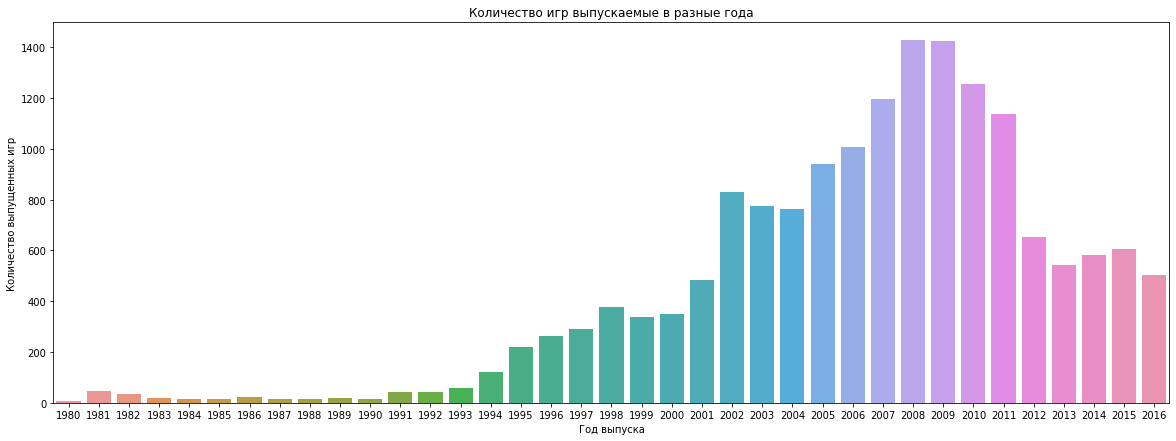

In [33]:
# Посмотрим сколько игр выпускалось в разные годы.
# Для этого с помощью своной таблицы соберем количество игр по годам и выведем на графике
games_period = data.pivot_table(index='year_of_release', values='name', aggfunc='count')
plt.figure(figsize=(20,7))
sns.barplot(data=games_period.reset_index(), x='year_of_release', y='name')
plt.title('Количество игр выпускаемые в разные года')
plt.xlabel('Год выпуска')
plt.ylabel('Количество выпущенных игр') 

None

<div class="alert alert-success">
<font size="4", color= "seagreen"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> Классный график, все элементы добавлены, молодец

Как мы видим пиковые значения приходятся на 2008 и 2009 года. Конечно, глубина данных интересна, но для прогноза мы отбросим данные за 2016 год, так как по условиям задачи данные не полные и на основании реккомендаций актуальный период зададим в 3 года, так как рынок игр динамичный, поэтому зададим новый актуальный период с 2013 по 2015 год.


### Создадим новую таблицу для анализа с данными за период с 2013 по 2015 год

In [34]:
# Создадим новую таблицу для анализа с данными за период с 2013 по 2015 год
working_data = data[(data['year_of_release']>=2013) & (data['year_of_release']<2016)]


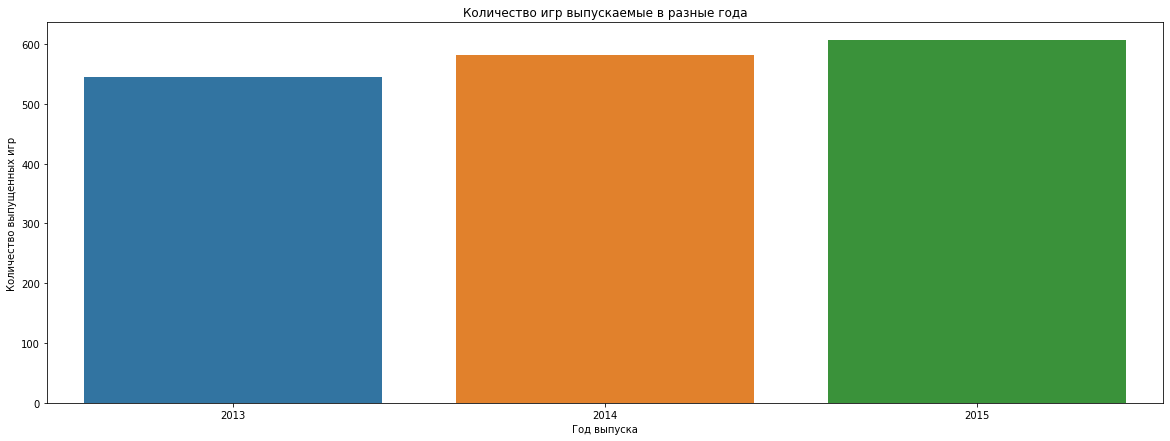

In [35]:
# посмотрим как выглядит график с данными за 2013 - 2015 года. 
games_period = working_data.pivot_table(index='year_of_release', values='name', aggfunc='count')
plt.figure(figsize=(20,7))
sns.barplot(data=games_period.reset_index(), x='year_of_release', y='name')
plt.title('Количество игр выпускаемые в разные года')
plt.xlabel('Год выпуска')
plt.ylabel('Количество выпущенных игр') 

None

### Проанализируем топ 5 платформ  за период с 2013 по 2015 год

In [36]:
# Посмотрим как менялись продажи по платформам.
# Выберем 5 платформ с наибольшими суммарными продажами 

display(data.groupby('platform').agg({'total_sales':'sum'}).sort_values('total_sales',ascending = False).head())


,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.76


In [37]:
# Создадим список 5ти платформ с наибольшими общими продажами
top_platforms = ['PS2', 'X360','PS3','Wii','DS']

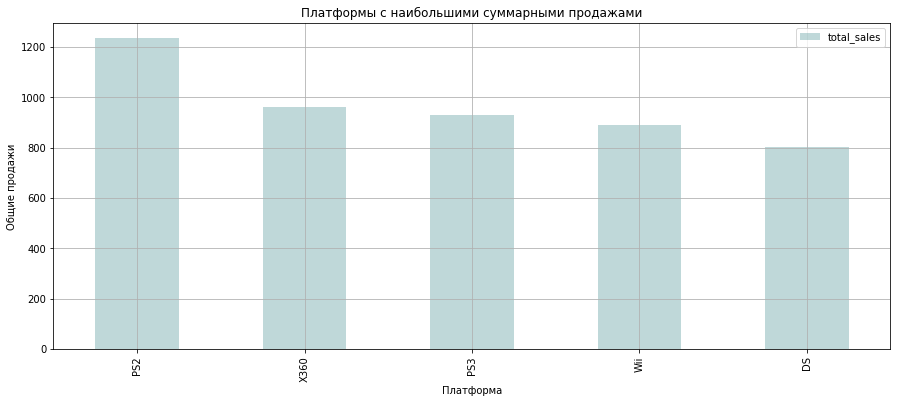

In [38]:
# Покажем графически 5ть платформ с наибольшими общими продажами

ax = data.query('platform in @top_platforms').pivot_table(values='total_sales', index='platform', aggfunc='sum')\
     .sort_values('total_sales',ascending = False)\
     .plot(title='Платформы с наибольшими суммарными продажами', 
     grid=True, kind='bar', style='o-', color='cadetblue', alpha=.4, figsize=(15, 6))
ax.set(xlabel='Платформа', ylabel='Общие продажи')
ax.get_yaxis().get_major_formatter().set_scientific(False)
None

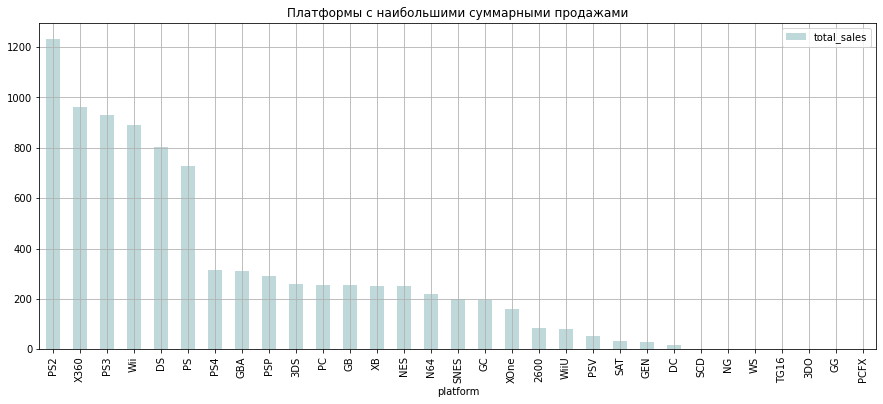

In [39]:
data.pivot_table(values='total_sales', index='platform', aggfunc='sum').sort_values('total_sales',ascending = False)\
    .plot(title='Платформы с наибольшими суммарными продажами', 
     grid=True, kind='bar', style='o-', color='cadetblue', alpha=.4, figsize=(15, 6))
ax.set(xlabel='Платформа', ylabel='Общие продажи')
ax.get_yaxis().get_major_formatter().set_scientific(False)
None

 Как мы видим по продажам лидирует PS2.

In [40]:
# Посмотрим как менялись продажи по платформам по годам. Используя пивот таблицу, соберем данные по общим продажам по пяти топовым платформам по годам
pivot_table_platforms = (data. query('platform in @top_platforms')
                            .pivot_table(index = ['platform','year_of_release'], values = 'total_sales', aggfunc = 'sum')
                            .reset_index())


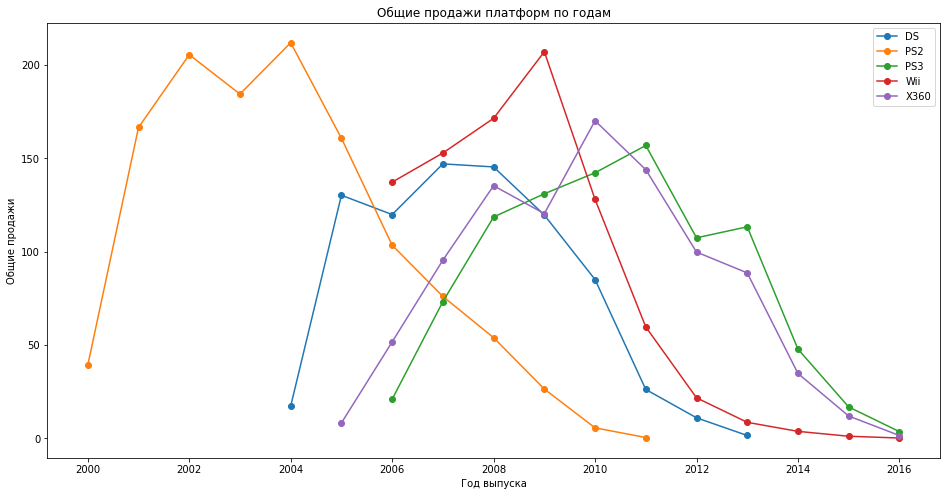

In [41]:
# Посмотрим как менялись продажи по платформам по годам на графике

plt.figure(figsize = (16,8))
for t in pivot_table_platforms['platform'].unique():
    plt.plot((pivot_table_platforms.loc[pivot_table_platforms['platform'] == t,'year_of_release']),
             (pivot_table_platforms.loc[pivot_table_platforms['platform'] == t,'total_sales']), linestyle='-', marker='o', label=t)
    plt.legend()
    plt.title('Общие продажи платформ по годам')
    plt.xlabel('Год выпуска')
    plt.ylabel('Общие продажи')
None   


** По графикам не возможно понять за какой характерный срок появляются новые и исчезают старые платформ. Очевидно, что есть цикличность, напоминающая букве М, но для Wii левой лапки не хватает.

Определим какие платформы лидируют по продажам, растут или падают. В данном пункте и далее будем работать с данными за период с 2013 года по 2015 год.

In [42]:
# Проверим изменился ли список 5 платформ с наибольшими суммарными продажами в актуальном периоде.
# Как мы видим пятерка осталась та же, произошла ракировка двух платформ.

display(working_data.groupby('platform').agg({'total_sales':'sum'}).sort_values('total_sales',ascending = False).head())
display(working_data.agg({'total_sales':'sum'}))


,total_sales
platform,
PS4,244.89
PS3,177.83
X360,135.28
XOne,133.17
3DS,128.11


total_sales    960.75
dtype: float64

In [43]:
# Создадим список 5ти платформ с наибольшими общими продажами для актуального периода. Как мы видим список сильно изменился.
top_platforms_act = ['PS4','PS3','X360','XOne','3DS']

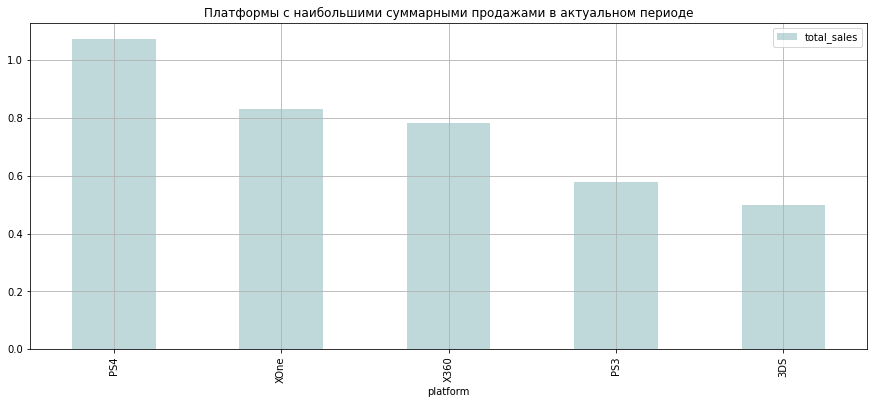

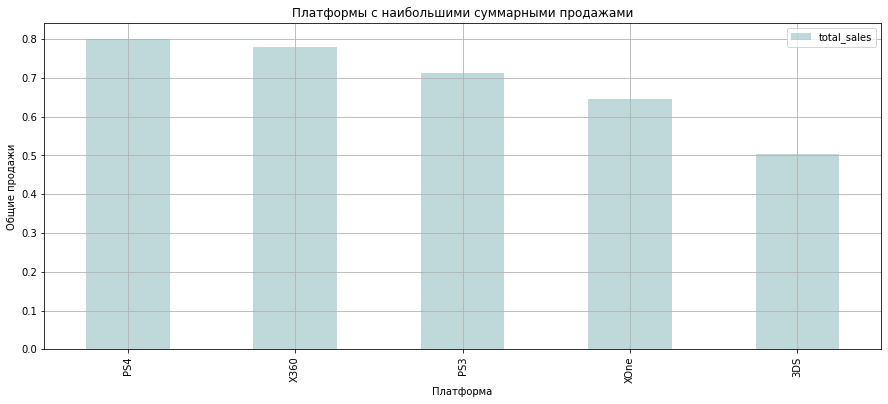

In [44]:
# Определим какие платформы лидируют по продажам, растут или падают. В данном пункте и далее будем работать с данными за период с 2002 года по 2015 год.


ax = working_data.query('platform in @top_platforms_act')\
      .pivot_table(values='total_sales', index='platform')\
      .sort_values('total_sales',ascending = False)\
      .plot(title='Платформы с наибольшими суммарными продажами в актуальном периоде', grid=True, kind='bar',
       style='o-', color='cadetblue', alpha=.4, figsize=(15, 6))
ax = data.query('platform in @top_platforms_act').pivot_table(values='total_sales', index='platform')\
      .sort_values('total_sales',ascending = False)\
      .plot(title='Платформы с наибольшими суммарными продажами', grid=True, kind='bar', style='o-',
        color='cadetblue', alpha=.4, figsize=(15, 6))
ax.set(xlabel='Платформа', ylabel='Общие продажи')
ax.get_yaxis().get_major_formatter().set_scientific(False)
None

In [45]:
#  Используя пивот таблицу, соберем данные по общим продажам по пяти топовым платформам по годам в актуальном периоде
pivot_table_platforms2 = (working_data. query('platform in @top_platforms_act')
                            .pivot_table(index = ['platform','year_of_release'], values = 'total_sales', aggfunc = 'sum')
                            .reset_index())

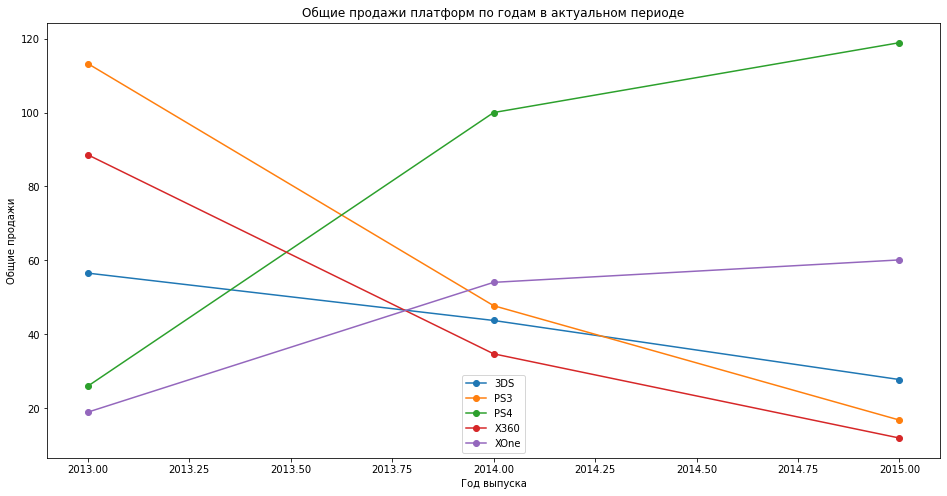

In [46]:
# Посмотрим как менялись продажи по платформам по годам в актуальном периоде на графике 

plt.figure(figsize = (16,8))
for t in pivot_table_platforms2['platform'].unique():
    plt.plot((pivot_table_platforms2.loc[pivot_table_platforms2['platform'] == t,'year_of_release']),
             (pivot_table_platforms2.loc[pivot_table_platforms2['platform'] == t,'total_sales']),
             linestyle='-', marker='o', label=t)
    plt.legend()
    plt.title('Общие продажи платформ по годам в актуальном периоде')
    plt.xlabel('Год выпуска')
    plt.ylabel('Общие продажи')
None   


Каждая из пяти выбранных платформ была прибыльна в тот или иной период времени в рамках актуального периода. 
Но в 2015 году только две показывают положительную динамику: PS4 и XOne.
Если бы у нас было больше информации, то можно было бы объединить PS - на графике очевидна смена PS3 PS4, предыдущая затухает, а новая стартует.

In [47]:
# Создадим новую таблицу для анализа с данными за период с 2013 по 2015 год по 5ти топовым платформам

working_data_top_platforms = working_data.query('platform in @top_platforms_act')
display(working_data_top_platforms.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,0,0.0,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,0,0.0,NaN,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62


### Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам

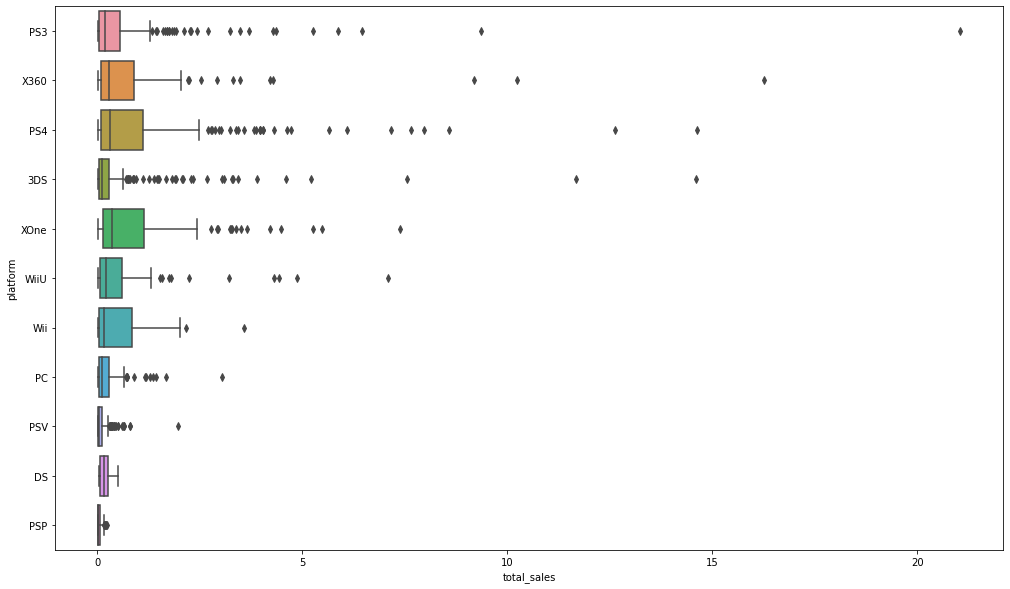

In [48]:
# Построим графики «ящик с усами» по глобальным продажам по всем играм за актуальный период
#working_data_pivot = working_data.pivot_table(index=['platform','year_of_release'], values='total_sales', aggfunc='sum').reset_index()
plt.figure(figsize=(17,10))
ax = sns.boxplot(x='total_sales', y = 'platform', data = working_data)

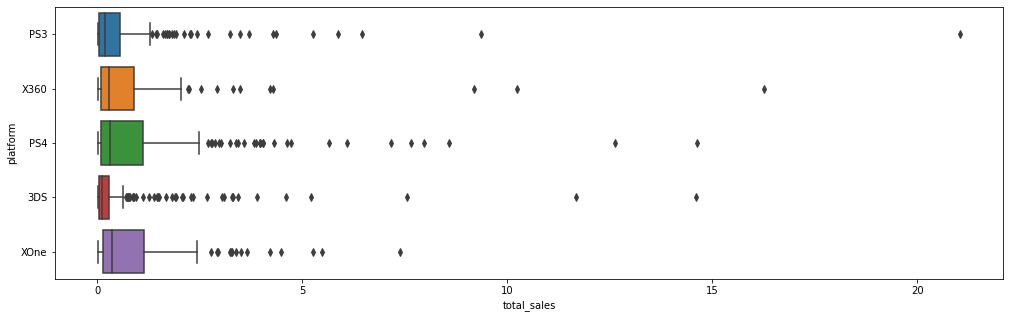

In [49]:
# Построим графики «ящик с усами» по глобальным продажам по 5ти топовым платформам за актуальный период
plt.figure(figsize=(17,5))
ax = sns.boxplot(x='total_sales', y = 'platform', data = working_data_top_platforms)

Мы наблюдаем достаточно большой интерквартильный разброс по платформам PS4 и XOne с медианой распределения, расположенной к минимальному значению. У платформы 3DS наиболее плотно сгруппированы данные.
По всем платформам медианы расположены ближе к минимальному значению.
По всем платформам наблюдаются единичные выбросы, не вписывающийся в промежуток значений, заданный усами графика, но наибольшие выбросы у платформы PS3.
Графики по другим платформам видны в предыдущем пункте и их значения уступают значениям топ 5. 

### Построим диаграмму рассеяния и посчитаем корреляцию

In [50]:
# Создадим пивот таблицы для анализа корреляций, убрав строки с отсутвтсвующим рейтингом
data_scores = data.loc[(data['user_score']!=0) & (data['critic_score']!=0)]

pivot_table_per_scores = (data_scores.query('platform in @top_platforms_act')
                            .pivot_table(index = ['platform','user_score','critic_score'], values = 'total_sales', aggfunc = 'sum')
                            .reset_index())


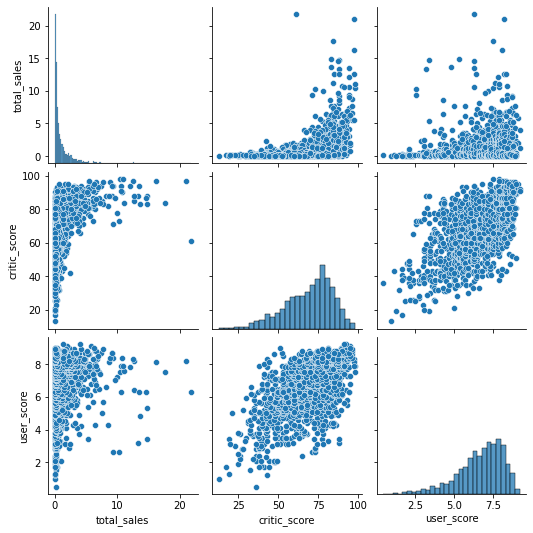

In [51]:
# Посмотрим как влияют на продажи внутри 5ти топовых платформ отзывы пользователей и критиков.
# Построим диаграммы рассеяния.
cols = ['total_sales','critic_score','user_score','platform']
sns_plot = sns.pairplot(pivot_table_per_scores[cols])
sns_plot.savefig('pairplot.png')


In [52]:
# Посчитаем корреляцию между отзывами и продажами.


corr_per_user_score = round(pivot_table_per_scores['total_sales'].corr(pivot_table_per_scores['user_score']),4)
 
display(f' коэффициент корреляции Пирсона (общие продажи и оценки пользователей): {corr_per_user_score}')

corr_per_critic_score = round(pivot_table_per_scores['total_sales'].corr(pivot_table_per_scores['critic_score']),4)
 
display(f' коэффициент корреляции Пирсона  (общие продажи и оценки критиков): {corr_per_critic_score}')

corr_per_scores = round(pivot_table_per_scores['user_score'].corr(pivot_table_per_scores['critic_score']),4)
 
display(f' коэффициент корреляции Пирсона  (оценки критиков и оценки пользователей): {corr_per_scores}')
 

' коэффициент корреляции Пирсона (общие продажи и оценки пользователей): 0.1545'

' коэффициент корреляции Пирсона  (общие продажи и оценки критиков): 0.4394'

' коэффициент корреляции Пирсона  (оценки критиков и оценки пользователей): 0.5901'

Корреляция в 0.1545 говорит об отсутствии связи между общими продажами и оценками пользователей и критиков, что подтверждают и диаграммы рассеивания.
Корреляция в 0.4394 говорит об умеренной связи между общими продажами и оценками критиков, что подтверждают и диаграммы рассеивания.
Прослеживается заметная связь между оценками пользователей и критиков, что подтверждают и диаграммы рассеивания по шкале Чеддока в 0.5901.

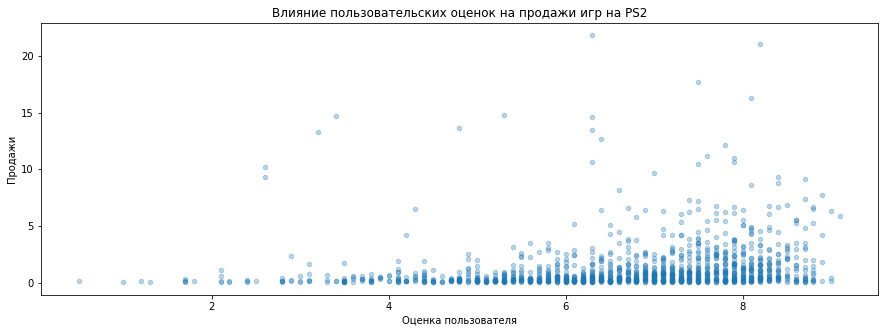

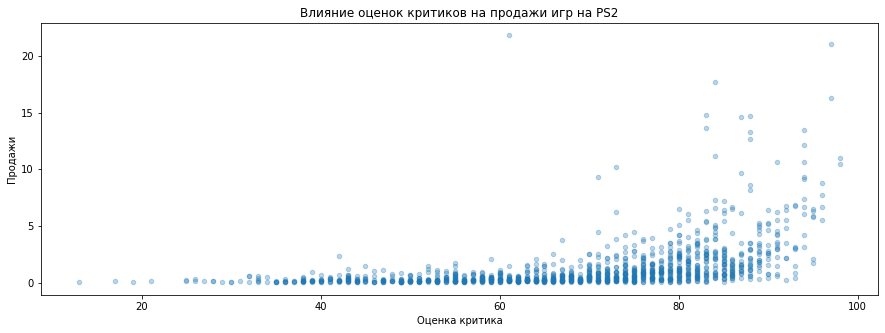

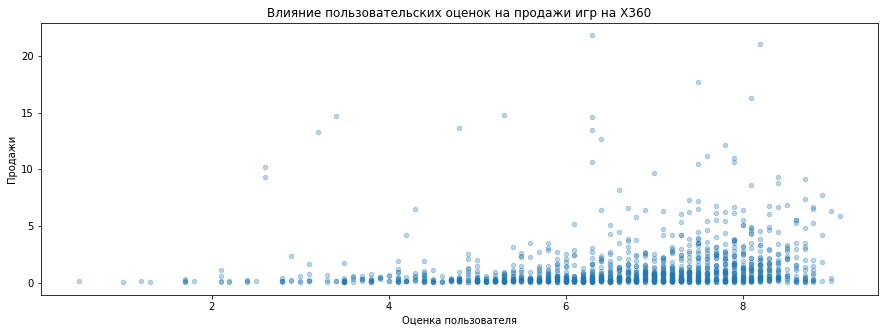

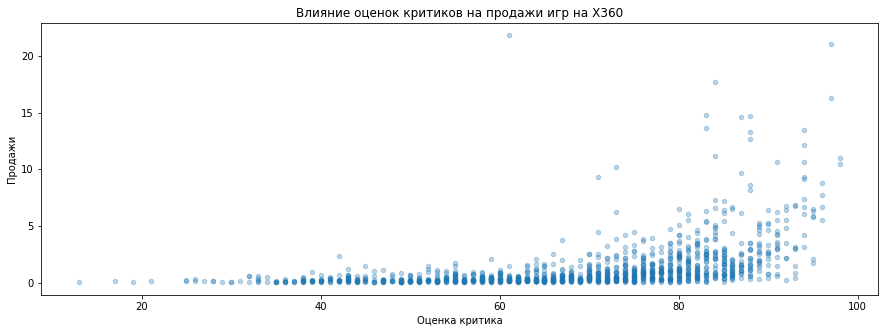

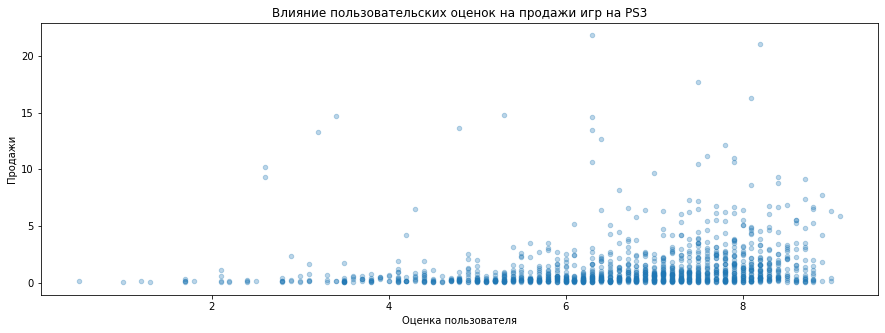

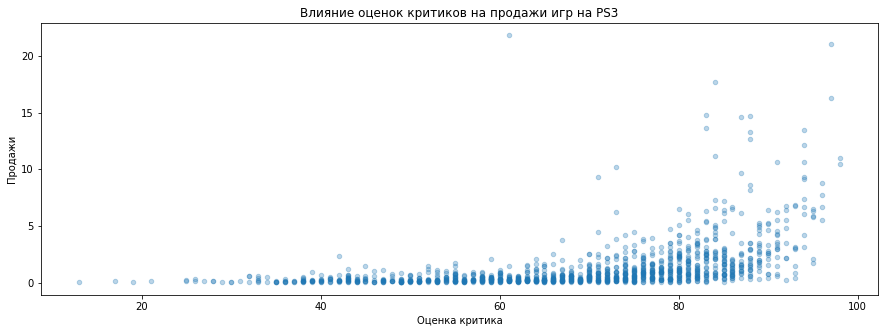

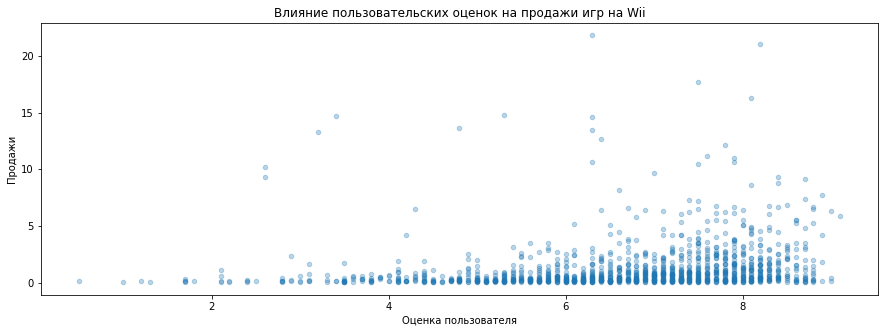

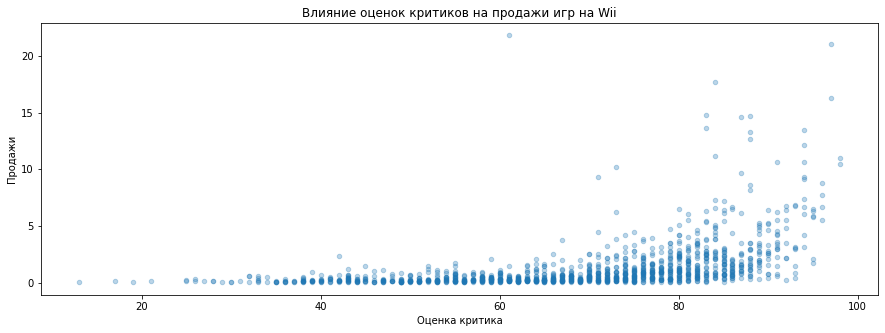

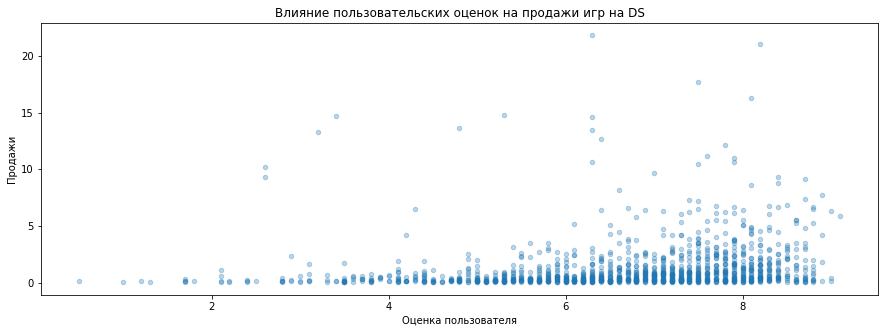

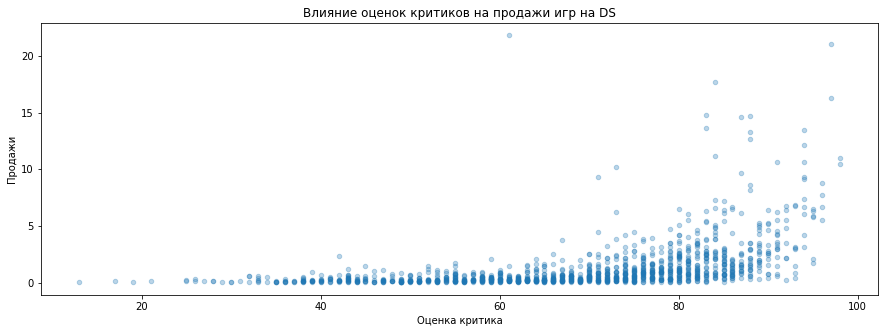

In [53]:
# Посмотрим как влияют на продажи внутри каждой из пяти популярных платформ отзывы пользователей и критиков.
# Построим диаграмму рассеяния каждой из пяти популярных платформ. 

for platform in top_platforms:
    x = pivot_table_per_scores.query('platform == @top_platforms')\
    .plot(x='user_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(15,5))\
    .set(title=f'Влияние пользовательских оценок на продажи игр на {platform}',xlabel='Оценка пользователя', 
         ylabel='Продажи')
    y = pivot_table_per_scores.query('platform == @top_platforms')\
    .plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(15,5))\
    .set(title=f'Влияние оценок критиков на продажи игр на {platform}',xlabel='Оценка критика', ylabel='Продажи')
    plt.show()


In [54]:
# Посчитаем корреляцию между отзывами и продажами для каждой из пяти популярных платформ.
for platform in pivot_table_per_scores['platform'].unique():
    correlation_user = round(pivot_table_per_scores.loc[pivot_table_per_scores['platform']== platform, 'user_score'].corr(pivot_table_per_scores['total_sales']),4)
    correlation_critic = round(pivot_table_per_scores.loc[pivot_table_per_scores['platform']== platform, 'critic_score'].corr(pivot_table_per_scores['total_sales']),4)
    display(f' Влияние оценок пользователей на продажи игр на платформе, {platform}, :, {correlation_user}')
    display(f' Влияние оценок критиков на продажи игр на платформе, {platform}, :, {correlation_critic}')

' Влияние оценок пользователей на продажи игр на платформе, 3DS, :, 0.2462'

' Влияние оценок критиков на продажи игр на платформе, 3DS, :, 0.3556'

' Влияние оценок пользователей на продажи игр на платформе, PS3, :, 0.2032'

' Влияние оценок критиков на продажи игр на платформе, PS3, :, 0.4769'

' Влияние оценок пользователей на продажи игр на платформе, PS4, :, -0.0191'

' Влияние оценок критиков на продажи игр на платформе, PS4, :, 0.4225'

' Влияние оценок пользователей на продажи игр на платформе, X360, :, 0.1769'

' Влияние оценок критиков на продажи игр на платформе, X360, :, 0.4538'

' Влияние оценок пользователей на продажи игр на платформе, XOne, :, -0.0689'

' Влияние оценок критиков на продажи игр на платформе, XOne, :, 0.4207'

    Все корреляции между оценками пользователей и продажами в диапазоне от -0,0689 до 0,2462, что говорит об отсутствии связи между общими продажами и оценками пользователей, что подтверждают и диаграммы рассеивания. 
    Все корреляции между оценками критиков и продажами в диапазоне от 0,3556 до 0,4769, что говорит об умеренной связи между общими продажами и оценками пользователей и критиков, что подтверждают и диаграммы рассеивания. 

In [55]:
pivot_table_per_scores_for_all = (data_scores
                            .pivot_table(index = ['platform','user_score', 'critic_score'], 
                             values = 'total_sales', aggfunc = 'sum')
                            .reset_index())

In [56]:
# Посчитаем корреляцию между оценками пользоваьелей и продажами для всех платформ.
display(f' Влияние оценок пользователей на продажи игр на платформе')
for platform in pivot_table_per_scores_for_all['platform'].unique():
    correlation = round(pivot_table_per_scores_for_all
                        .loc[pivot_table_per_scores_for_all['platform']== platform, 'user_score']
                        .corr(pivot_table_per_scores_for_all['total_sales']),4)
    display(f' {platform} :, {correlation}')


' Влияние оценок пользователей на продажи игр на платформе'

' 3DS :, 0.2462'

' DC :, -0.227'

' DS :, 0.1699'

' GBA :, 0.1264'

' GC :, 0.2658'

' PC :, 0.0493'

' PS :, 0.3077'

' PS2 :, 0.2684'

' PS3 :, 0.2032'

' PS4 :, -0.0191'

' PSP :, 0.2622'

' PSV :, 0.0644'

' Wii :, 0.1428'

' WiiU :, 0.3961'

' X360 :, 0.1769'

' XB :, 0.2388'

' XOne :, -0.0689'

    Большинство корреляций между оценками пользователей и продажами в диапазоне менее 0,3, что говорит об отсутствии связи между общими продажами и оценками пользователей, что подтверждают и диаграммы рассеивания. 
    По двум платформам WiiU и PS корреляция чуть более 0,3, что говорит об умеренной связи, но эти платформы не входят в том 5.
   

In [57]:
# Посчитаем корреляцию между оценками критиков и продажами для всех платформ.
display(f' Влияние оценок критиков на продажи игр на платформе')
for platform in pivot_table_per_scores_for_all['platform'].unique():
    correlation = round(pivot_table_per_scores_for_all
                        .loc[pivot_table_per_scores_for_all['platform']== platform, 'user_score']
                        .corr(pivot_table_per_scores_for_all['total_sales']),4)
    display(f' {platform} :, {correlation}')


' Влияние оценок критиков на продажи игр на платформе'

' 3DS :, 0.2462'

' DC :, -0.227'

' DS :, 0.1699'

' GBA :, 0.1264'

' GC :, 0.2658'

' PC :, 0.0493'

' PS :, 0.3077'

' PS2 :, 0.2684'

' PS3 :, 0.2032'

' PS4 :, -0.0191'

' PSP :, 0.2622'

' PSV :, 0.0644'

' Wii :, 0.1428'

' WiiU :, 0.3961'

' X360 :, 0.1769'

' XB :, 0.2388'

' XOne :, -0.0689'

  Большинство корреляций между оценками критиков и продажами в диапазоне менее 0,3, что говорит об отсутствии связи между общими продажами и оценками пользователей, что подтверждают и диаграммы рассеивания. 
    По двум платформам WiiU и PS корреляция чуть более 0,3, что говорит об умеренной связи, но эти платформы не входят в том 5.
   

###  Посмотрим на общее распределение игр по жанрам

In [58]:
display(working_data.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,0,0.0,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,0,0.0,NaN,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62


In [59]:
# Выберем 5 жанров с наибольшими суммарными продажами в актуальном периоде
display(working_data.groupby('genre').agg({'total_sales':'sum'}).sort_values('total_sales',ascending = False).head())
# display(working_data.agg({'total_sales':'sum'}))


,total_sales
genre,
Action,291.76
Shooter,194.76
Role-Playing,127.71
Sports,127.16
Misc,60.22


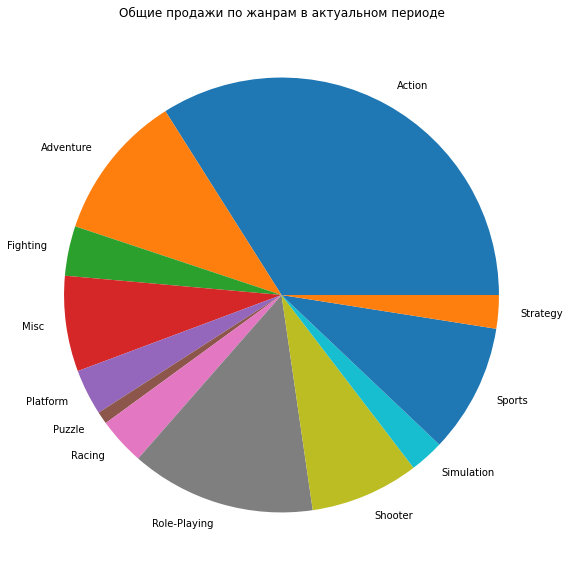

In [60]:
# Посмотрите на общее распределение игр по жанрам.
working_data.groupby('genre').size().plot(kind='pie', subplots=True, figsize=(10, 10))
plt.title("Общие продажи по жанрам в актуальном периоде")
plt.ylabel("")
plt.show()

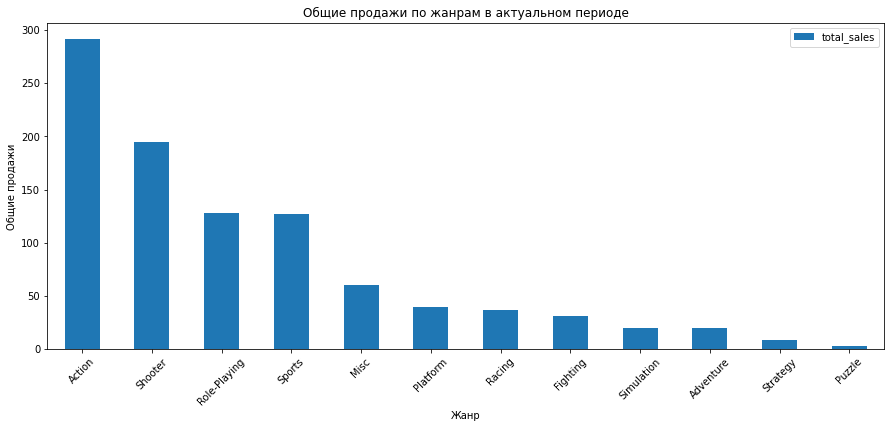

In [61]:
# Посмотрите на общее распределение игр по жанрам.
working_data.groupby('genre').agg({'total_sales':'sum'}).sort_values('total_sales',ascending = False)\
     .plot(kind='bar', rot=45, figsize = (15,6))
plt.title('Общие продажи по жанрам в актуальном периоде')
plt.xlabel('Жанр')
plt.ylabel('Общие продажи')
None   

In [62]:
# Создадим список 5ти платформ с наибольшими общими продажами
top_genres = ['Action','Shooter','Role-Playing','Sports', 'Misc']

In [63]:
pivot_table_genre = (working_data. query('genre in @top_genres')
                            .pivot_table(index = ['genre','year_of_release'], values = 'total_sales', aggfunc = 'sum')
                            .reset_index())

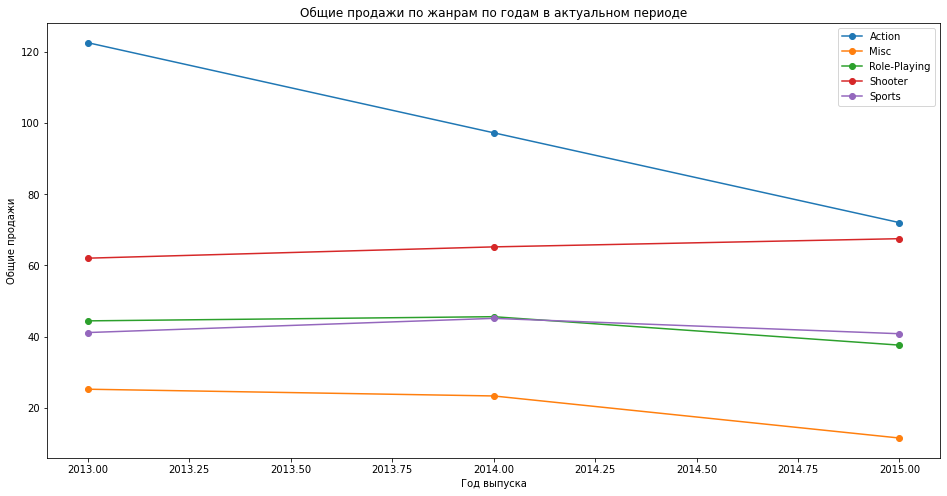

In [64]:
# Посмотрим как менялись продажи по платформам по годам в актуальном периоде на графике 


plt.figure(figsize = (16,8))
for t in pivot_table_genre['genre'].unique():
    plt.plot((pivot_table_genre.loc[pivot_table_genre['genre'] == t,'year_of_release']),
             (pivot_table_genre.loc[pivot_table_genre['genre'] == t,'total_sales']), linestyle='-', marker='o', label=t)
    plt.legend()
    plt.title('Общие продажи по жанрам по годам в актуальном периоде')
    plt.xlabel('Год выпуска')
    plt.ylabel('Общие продажи')
None   

На графике видно, что доходность 4х из 5ти топовых жанров в последние годы снижаются. 
Только жанр Shooter показывает небольшой рост.

In [65]:
# Создадим новую таблицу для анализа с данными за период с 2013 по 2015 год по 5ти топовым жанрам

working_data_top_genres = working_data.query('genre in @top_genres')
display(working_data_top_genres.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,0,0.0,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,0,0.0,NaN,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62


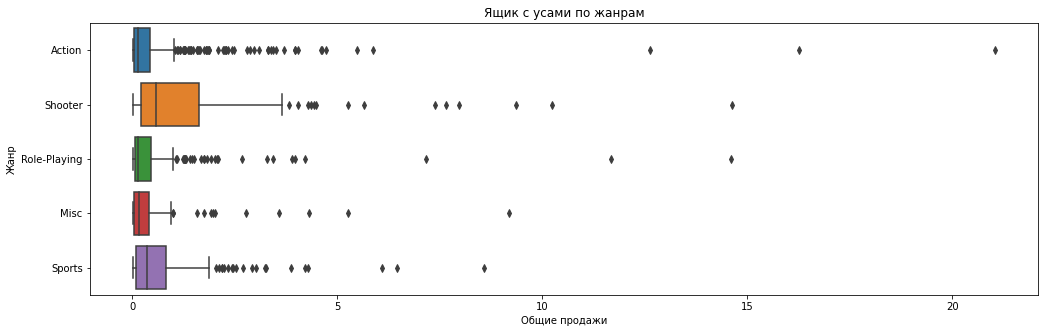

In [66]:
# Построим графики «ящик с усами» по глобальным продажам по 5ти топовым жанрам за актуальный период
plt.figure(figsize=(17,5))
ax = sns.boxplot(x='total_sales', y = 'genre', data = working_data_top_genres)
ax.set_title('Ящик с усами по жанрам')
ax.set_ylabel('Жанр')
ax.set_xlabel('Общие продажи')
None

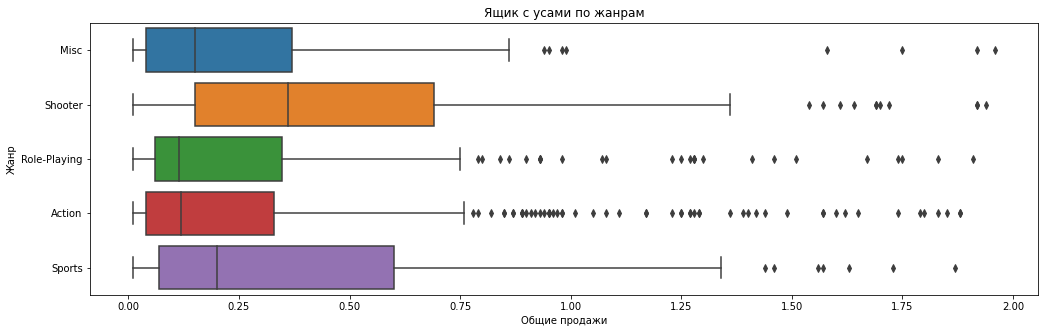

In [67]:
working_data_top_genres_cut = working_data_top_genres[working_data_top_genres['total_sales']<2]
plt.figure(figsize=(17,5))
ax = sns.boxplot(x='total_sales', y = 'genre', data = working_data_top_genres_cut)
ax.set_title('Ящик с усами по жанрам')
ax.set_ylabel('Жанр')
ax.set_xlabel('Общие продажи')
None


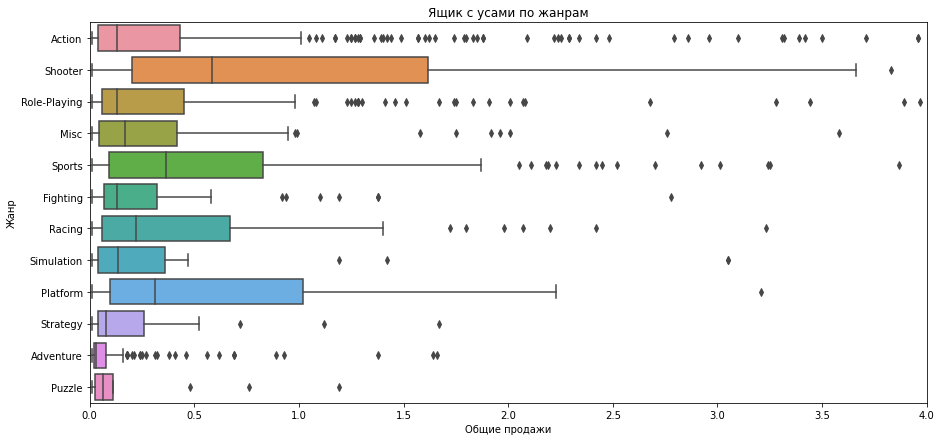

In [68]:
# Построим графики «ящик с усами» по глобальным продажам по 5ти топовым жанрам за актуальный период с видимым 0,75 квантиль 

plt.figure(figsize=(15,7))
ax = sns.boxplot(x='total_sales', y = 'genre', data = working_data)
ax.set_title('Ящик с усами по жанрам')
ax.set_ylabel('Жанр')
ax.set_xlabel('Общие продажи')
plt.xlim(0,4);



## Шаг 4. Составьте портрет пользователя каждого региона

### Определим самые популярные платформы (топ-5) для пользователя каждого региона (NA, EU, JP)


In [69]:
# Самые популярные платформы (топ-5)  в Северной Америке 
display(working_data.groupby('platform').agg({'na_sales':'sum'}).sort_values('na_sales',ascending = False).head())
print(working_data.agg({'na_sales':'sum'}))


,na_sales
platform,
PS4,87.25
X360,80.97
XOne,78.85
PS3,62.83
3DS,34.06


na_sales    392.78
dtype: float64


In [70]:
platform_na_sales = (working_data
                            .pivot_table(index = ['platform'], values = 'na_sales', aggfunc = 'sum')
                            .reset_index())
platform_na_sales['platform_na_sales_%'] = round(platform_na_sales['na_sales']/working_data['na_sales'].sum()*100,2)
display(platform_na_sales)

,platform,na_sales,platform_na_sales_%
0,3DS,34.06,8.67
1,DS,0.57,0.15
2,PC,9.75,2.48
3,PS3,62.83,16.00
4,PS4,87.25,22.21
5,PSP,0.00,0.00
6,PSV,4.89,1.24
7,Wii,6.50,1.65
8,WiiU,27.11,6.90
9,X360,80.97,20.61


In [71]:
# Самые популярные платформы (топ-5)  в Европе
display(working_data.groupby('platform').agg({'eu_sales':'sum'}).sort_values('eu_sales',ascending = False))
display(working_data.agg({'eu_sales':'sum'}))


,eu_sales
platform,
PS4,109.31
PS3,66.55
XOne,41.96
X360,41.81
3DS,28.63
PC,21.83
WiiU,18.37
Wii,5.82
PSV,5.71


eu_sales    341.01
dtype: float64

In [72]:
platform_eu_sales = (working_data
                            .pivot_table(index = ['platform'], values = 'eu_sales', aggfunc = 'sum')
                            .reset_index())
platform_eu_sales['platform_eu_sales_%'] = round(platform_eu_sales['eu_sales']/working_data['eu_sales'].sum()*100,2)
display(platform_eu_sales)

,platform,eu_sales,platform_eu_sales_%
0,3DS,28.63,8.40
1,DS,0.85,0.25
2,PC,21.83,6.40
3,PS3,66.55,19.52
4,PS4,109.31,32.05
5,PSP,0.17,0.05
6,PSV,5.71,1.67
7,Wii,5.82,1.71
8,WiiU,18.37,5.39
9,X360,41.81,12.26


In [73]:
# Самые популярные платформы (топ-5) в Японии
display(working_data.groupby('platform').agg({'jp_sales':'sum'}).sort_values('jp_sales',ascending = False))
display(working_data.agg({'jp_sales':'sum'}))


,jp_sales
platform,
3DS,59.78
PS3,22.05
PSV,15.03
PS4,10.22
WiiU,10.21
PSP,3.29
X360,0.51
XOne,0.33
Wii,0.05


jp_sales    121.47
dtype: float64

In [74]:
platform_jp_sales = (working_data
                            .pivot_table(index = ['platform'], values = 'jp_sales', aggfunc = 'sum')
                            .reset_index())
platform_jp_sales['platform_jp_sales_%'] = round(platform_jp_sales['jp_sales']/working_data['jp_sales'].sum()*100,2)
display(platform_jp_sales)

,platform,jp_sales,platform_jp_sales_%
0,3DS,59.78,49.21
1,DS,0.00,0.00
2,PC,0.00,0.00
3,PS3,22.05,18.15
4,PS4,10.22,8.41
5,PSP,3.29,2.71
6,PSV,15.03,12.37
7,Wii,0.05,0.04
8,WiiU,10.21,8.41
9,X360,0.51,0.42


In [75]:
platform_total_sales = (working_data
                            .pivot_table(index = ['platform'], values = 'total_sales', aggfunc = 'sum')
                            .reset_index())
platform_total_sales['platform_total_sales_%'] = round(platform_total_sales['total_sales']/working_data['total_sales'].sum()*100,2)
display(platform_total_sales)

,platform,total_sales,platform_total_sales_%
0,3DS,128.11,13.33
1,DS,1.54,0.16
2,PC,34.18,3.56
3,PS3,177.83,18.51
4,PS4,244.89,25.49
5,PSP,3.50,0.36
6,PSV,28.74,2.99
7,Wii,13.48,1.40
8,WiiU,60.03,6.25
9,X360,135.28,14.08


In [76]:
platform_total_sales['platform_na_sales_%']=  platform_na_sales['platform_na_sales_%']
platform_total_sales['platform_eu_sales_%']=  platform_eu_sales['platform_eu_sales_%']
platform_total_sales['platform_jp_sales_%']=  platform_jp_sales['platform_jp_sales_%']
display(platform_total_sales.sort_values('platform_total_sales_%',ascending = False))


,platform,total_sales,platform_total_sales_%,platform_na_sales_%,platform_eu_sales_%,platform_jp_sales_%
4,PS4,244.89,25.49,22.21,32.05,8.41
3,PS3,177.83,18.51,16.00,19.52,18.15
9,X360,135.28,14.08,20.61,12.26,0.42
10,XOne,133.17,13.86,20.07,12.30,0.27
0,3DS,128.11,13.33,8.67,8.40,49.21
8,WiiU,60.03,6.25,6.90,5.39,8.41
2,PC,34.18,3.56,2.48,6.40,0.00
6,PSV,28.74,2.99,1.24,1.67,12.37
7,Wii,13.48,1.40,1.65,1.71,0.04
5,PSP,3.50,0.36,0.00,0.05,2.71


Как мы видим самые полулярные платформы похожи в разных регионах, исключением является Япония: в которой почти четверть продаж составляют DS, продажи которой в остальных регионах составляют около 10%. 
В остальных регионах наибольшие продажи приходятся на PS2 - чуть около 15%, в Японии тоже чуть более 15%.

### Определим самые популярные жанры (топ-5) для пользователя каждого региона (NA, EU, JP)

In [77]:
# Выберем 5 жанров с наибольшими суммарными продажами в актуальном периоде по регионам:
# продажи в Северной Америке 
display(working_data.groupby('genre').agg({'na_sales':'sum'}).sort_values('na_sales',ascending = False))
display(working_data.agg({'na_sales':'sum'}))

,na_sales
genre,
Action,116.76
Shooter,93.50
Sports,57.73
Role-Playing,40.51
Misc,26.73
Platform,16.85
Fighting,13.71
Racing,12.23
Adventure,6.19


na_sales    392.78
dtype: float64

In [78]:
pivot_table_na_sales = (working_data
                            .pivot_table(index = ['genre'], values = 'na_sales', aggfunc = 'sum')
                            .reset_index())
pivot_table_na_sales['na_sales_%'] = round(pivot_table_na_sales['na_sales']/working_data['na_sales'].sum()*100,2)
display(pivot_table_na_sales)

,genre,na_sales,na_sales_%
0,Action,116.76,29.73
1,Adventure,6.19,1.58
2,Fighting,13.71,3.49
3,Misc,26.73,6.81
4,Platform,16.85,4.29
5,Puzzle,0.83,0.21
6,Racing,12.23,3.11
7,Role-Playing,40.51,10.31
8,Shooter,93.50,23.80
9,Simulation,4.70,1.20


In [79]:
# продажи в Европе
display(working_data.groupby('genre').agg({'eu_sales':'sum'}).sort_values('eu_sales',ascending = False))
display(working_data.agg({'eu_sales':'sum'}))

,eu_sales
genre,
Action,107.45
Shooter,71.96
Sports,48.51
Role-Playing,32.69
Misc,19.38
Racing,18.42
Platform,14.19
Simulation,9.65
Fighting,7.21


eu_sales    341.01
dtype: float64

In [80]:
pivot_table_eu_sales = (working_data
                            .pivot_table(index = ['genre'], values = 'eu_sales', aggfunc = 'sum')
                            .reset_index())
pivot_table_eu_sales['eu_sales_%'] = round(pivot_table_eu_sales['eu_sales']/working_data['eu_sales'].sum()*100,2)
display(pivot_table_eu_sales)

,genre,eu_sales,eu_sales_%
0,Action,107.45,31.51
1,Adventure,6.93,2.03
2,Fighting,7.21,2.11
3,Misc,19.38,5.68
4,Platform,14.19,4.16
5,Puzzle,0.99,0.29
6,Racing,18.42,5.40
7,Role-Playing,32.69,9.59
8,Shooter,71.96,21.10
9,Simulation,9.65,2.83


In [81]:
# продажи в Японии
display(working_data.groupby('genre').agg({'jp_sales':'sum'}).sort_values('jp_sales',ascending = False))
display(working_data.agg({'jp_sales':'sum'}))

,jp_sales
genre,
Role-Playing,44.43
Action,33.42
Misc,8.16
Fighting,6.90
Shooter,5.55
Platform,4.68
Adventure,4.64
Sports,4.49
Simulation,4.19


jp_sales    121.47
dtype: float64

In [82]:
pivot_table_jp_sales = (working_data
                            .pivot_table(index = ['genre'], values = 'jp_sales', aggfunc = 'sum')
                            .reset_index())
pivot_table_jp_sales['jp_sales_%'] = round(pivot_table_jp_sales['jp_sales']/working_data['jp_sales'].sum()*100,2)
display(pivot_table_jp_sales)

,genre,jp_sales,jp_sales_%
0,Action,33.42,27.51
1,Adventure,4.64,3.82
2,Fighting,6.90,5.68
3,Misc,8.16,6.72
4,Platform,4.68,3.85
5,Puzzle,1.18,0.97
6,Racing,2.29,1.89
7,Role-Playing,44.43,36.58
8,Shooter,5.55,4.57
9,Simulation,4.19,3.45


In [83]:
pivot_table_total_sales = (working_data
                            .pivot_table(index = ['genre'], values = 'total_sales', aggfunc = 'sum')
                            .reset_index())
pivot_table_total_sales['total_sales_%'] = round(pivot_table_total_sales['total_sales']/working_data['total_sales'].sum()*100,2)
print(pivot_table_total_sales)

           genre  total_sales  total_sales_%
0         Action       291.76          30.37
1      Adventure        19.82           2.06
2       Fighting        30.84           3.21
3           Misc        60.22           6.27
4       Platform        39.40           4.10
5         Puzzle         3.16           0.33
6         Racing        37.10           3.86
7   Role-Playing       127.71          13.29
8        Shooter       194.76          20.27
9     Simulation        19.87           2.07
10        Sports       127.16          13.24
11      Strategy         8.95           0.93


In [84]:
pivot_table_total_sales['na_sales_%']=  pivot_table_na_sales['na_sales_%']
pivot_table_total_sales['eu_sales_%']=  pivot_table_eu_sales['eu_sales_%']
pivot_table_total_sales['jp_sales_%']=  pivot_table_jp_sales['jp_sales_%']
display(pivot_table_total_sales.sort_values('total_sales_%',ascending = False))


,genre,total_sales,total_sales_%,na_sales_%,eu_sales_%,jp_sales_%
0,Action,291.76,30.37,29.73,31.51,27.51
8,Shooter,194.76,20.27,23.80,21.10,4.57
7,Role-Playing,127.71,13.29,10.31,9.59,36.58
10,Sports,127.16,13.24,14.70,14.23,3.70
3,Misc,60.22,6.27,6.81,5.68,6.72
4,Platform,39.40,4.10,4.29,4.16,3.85
6,Racing,37.10,3.86,3.11,5.40,1.89
2,Fighting,30.84,3.21,3.49,2.11,5.68
9,Simulation,19.87,2.07,1.20,2.83,3.45
1,Adventure,19.82,2.06,1.58,2.03,3.82


Как мы видим самые полулярные жанры похожи в разных регионах, исключением является Япония: в которой почти 37% продаж составляют Role-Playing, продажи которой в остальных регионах составляют менее 10%. 
В остальных регионах наибольшие продажи приходятся на Action - чуть более 30%.

In [85]:
# создадим таблицы для построения графиков и объединим все жанры, не входящие в топ5 в OTHER
genre_na = (
     working_data
    .pivot_table(index = 'genre', values = 'na_sales', aggfunc = 'sum')
    .reset_index() 
)
genre_na['persentage'] = round((genre_na['na_sales'] / genre_na['na_sales'].sum()) * 100, 1)
genre_na['group_name'] = (genre_na['genre'].where(genre_na['genre'].isin (['Action','Shooter','Role-Playing','Sports', 'Misc']) , 'Other'))
genre_na=genre_na.groupby('group_name')['persentage'].sum()

print(genre_na)

group_name
Action          29.7
Misc             6.8
Other           14.7
Role-Playing    10.3
Shooter         23.8
Sports          14.7
Name: persentage, dtype: float64


In [86]:
# создадим таблицы для построения графиков и объединим все жанры, не входящие в топ5 в OTHER
genre_eu = (
     working_data
    .pivot_table(index = 'genre', values = 'eu_sales', aggfunc = 'sum')
    .reset_index() 
)
genre_eu['persentage'] = round((genre_eu['eu_sales'] / genre_eu['eu_sales'].sum()) * 100, 1)
genre_eu['group_name'] = (genre_eu['genre'].where(genre_eu['genre'].isin (['Action','Shooter','Role-Playing','Sports', 'Misc']) , 'Other'))
genre_eu=genre_eu.groupby('group_name')['persentage'].sum()

print(genre_eu)

group_name
Action          31.5
Misc             5.7
Other           17.9
Role-Playing     9.6
Shooter         21.1
Sports          14.2
Name: persentage, dtype: float64


In [87]:
# создадим таблицы для построения графиков и объединим все жанры, не входящие в топ5 в OTHER
genre_jp = (
     working_data
    .pivot_table(index = 'genre', values = 'jp_sales', aggfunc = 'sum')
    .reset_index() 
)
genre_jp['persentage'] = round((genre_jp['jp_sales'] / genre_jp['jp_sales'].sum()) * 100, 1)
genre_jp['group_name'] = (genre_jp['genre'].where(genre_jp['genre'].isin (['Role-Playing','Action','Misc','Fighting','Shooter']) , 'Other'))
genre_jp=genre_jp.groupby('group_name')['persentage'].sum()

print(genre_jp)

group_name
Action          27.5
Fighting         5.7
Misc             6.7
Other           19.0
Role-Playing    36.6
Shooter          4.6
Name: persentage, dtype: float64


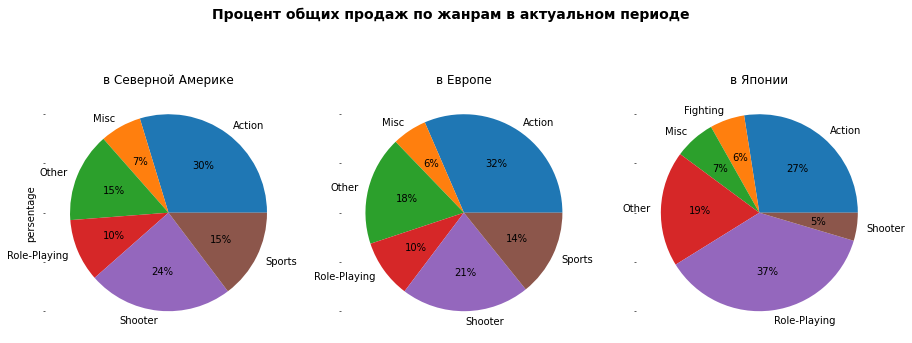

In [88]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15, 6))
genre_na.plot(y='persentage', x='group_name', kind='pie', autopct ='%.0f%%', ax=ax0, subplots=True)
ax0.set(title="в Северной Америке")

genre_eu.plot(y='persentage', x='group_name', kind='pie', autopct ='%.0f%%', ax=ax1, subplots=True)
ax1.set(title="в Европе")

genre_jp.plot(y='persentage', x='group_name', kind='pie', autopct ='%.0f%%', ax=ax2, subplots=True)
ax2.set(title="в Японии")

fig.suptitle('Процент общих продаж по жанрам в актуальном периоде', fontsize=14, fontweight ='bold')
ax2.legend().set_visible(False)
ax1.legend().set_visible(False)
ax0.legend().set_visible(False)

In [89]:
# Заменим пропуски в рейтинге ESRB на 'no_rating'
working_data['rating'] = working_data['rating'].fillna("no_rating")


/tmp/ipykernel_182/1185568172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_data['rating'] = working_data['rating'].fillna("no_rating")


In [90]:
# Создадим пивот таблицы 
pivot_table_per_rating = (working_data
                            .pivot_table(index = 'rating',
                             values = ['total_sales', 'na_sales', 'eu_sales', 'jp_sales'], aggfunc = 'sum')
                            .reset_index())
display(pivot_table_per_rating)

,rating,eu_sales,jp_sales,na_sales,total_sales
0,E,69.75,14.07,71.08,174.42
1,E10+,38.88,5.44,50.43,106.26
2,M,128.78,12.91,149.54,333.33
3,T,32.16,18.32,40.84,102.50
4,no_rating,71.44,70.73,80.89,244.24


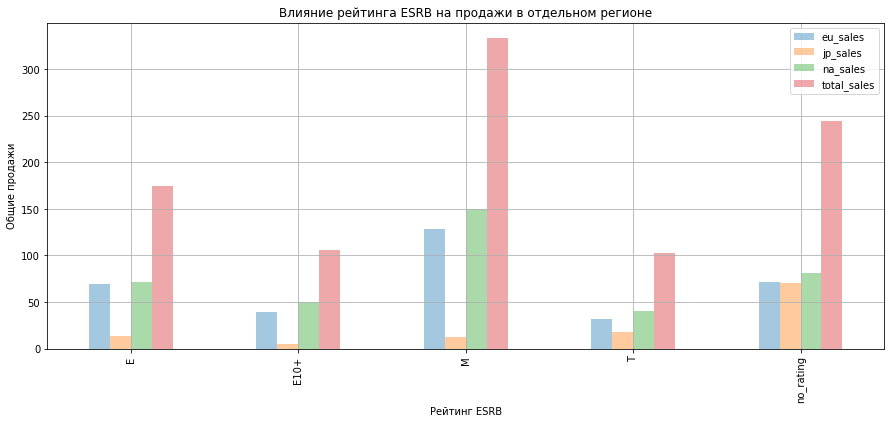

In [91]:
# Посмотрим влияет ли рейтинг ESRB на продажи в отдельном регионе
pivot_table_per_rating.plot(title='Влияние рейтинга ESRB на продажи в отдельном регионе', x='rating',xlabel='Рейтинг ESRB', ylabel='Общие продажи', grid=True, kind='bar', alpha=.4, figsize=(15, 6))

None

Как мы видим рейтинг ESRB влияет на продажи в отдельных регионах: лучше всего продаются игры с рейтингом М, но это объясняется и частотой его использования.


In [92]:
# Создадим пивот таблицы 
pivot_table_per_rating = (working_data
                            .pivot_table(index = 'rating',
                             values = ['total_sales', 'na_sales', 'eu_sales', 'jp_sales'], aggfunc = 'count')
                            .reset_index())
pivot_table_per_rating['persentage'] = round((pivot_table_per_rating['total_sales'] / pivot_table_per_rating['total_sales']
                                                 .sum()) * 100, 1)
display(pivot_table_per_rating)

,rating,eu_sales,jp_sales,na_sales,total_sales,persentage
0,E,236,236,236,236,13.6
1,E10+,202,202,202,202,11.7
2,M,291,291,291,291,16.8
3,T,247,247,247,247,14.3
4,no_rating,755,755,755,755,43.6


In [93]:
data_na = working_data.loc[working_data['na_sales']>0]
pivot_table_per_rating_na = (data_na.pivot_table(index = 'rating',values = 'na_sales', aggfunc = 'count'))
pivot_table_per_rating_na['persentage'] = round((pivot_table_per_rating_na['na_sales'] / pivot_table_per_rating_na['na_sales']
                                                 .sum()) * 100, 1)
display(pivot_table_per_rating_na)

,na_sales,persentage
rating,,
E,171,16.7
E10+,173,16.8
M,264,25.7
T,173,16.8
no_rating,246,24.0


In [94]:
data_eu = working_data.loc[working_data['eu_sales']>0]
pivot_table_per_rating_eu = (data_eu.pivot_table(index = 'rating',values = 'eu_sales', aggfunc = 'count'))
pivot_table_per_rating_eu['persentage'] = round((pivot_table_per_rating_eu['eu_sales'] / pivot_table_per_rating_eu['eu_sales']
                                                 .sum()) * 100, 1)
display(pivot_table_per_rating_eu)

,eu_sales,persentage
rating,,
E,211,18.5
E10+,192,16.9
M,276,24.2
T,185,16.2
no_rating,275,24.1


In [95]:
data_jp = working_data.loc[working_data['jp_sales']>0]
pivot_table_per_rating_jp = (data_jp.pivot_table(index = 'rating',values = 'jp_sales', aggfunc = 'count'))
pivot_table_per_rating_jp['persentage'] = round((pivot_table_per_rating_jp['jp_sales'] / pivot_table_per_rating_jp['jp_sales']
                                                 .sum()) * 100, 1)
display(pivot_table_per_rating_jp)

,jp_sales,persentage
rating,,
E,66,6.9
E10+,49,5.2
M,139,14.6
T,148,15.6
no_rating,549,57.7


    Как мы видим очень много данных без рейтинга - 755 из 1731, т.е. около 44% от всех данных. Мы видим, что и количество случаев проставления рейтинга М чуть больше, чем остальных - примерно 17%. Можно сказать, что количество тех или иных рейтингов проставляеся пости с одинаковой частотой - от 11,7% до 16.8%. 
    Как мы видим на Японском рынке совсем другая картина - количество продаж без рейтинга достигают 57.7%, тогда как в Европе и Северной Америке это только 24%. В Японии наиболее часто используется рейтиг Т - 15.6%, хотя рейтинг М ненамного отстает - 14.6%.

## Шаг 5. Проверка гипотез

### Проверим гипотезу, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые


#### Сформулируем гипотезы

Сформулируем нулевую гипотезу:

Н0 - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Сформулируем альтернативную гипотезу:

Н1 - Средние пользовательские рейтинги платформ Xbox One и PC не одинаковые
    

#### Проверим гипотезу: средние пользовательские рейтинги платформ Xbox One и PC одинаковые

In [96]:
# Проверим гипотезу: средние пользовательские рейтинги платформ Xbox One и PC одинаковые
working_data_scores = working_data.loc[working_data['user_score']>0]
mean_Xbox_One = working_data_scores.query('platform == "XOne"')['user_score']
mean_PC = working_data_scores.query('platform == "PC"')['user_score']

 
alpha = 0.05


results = st.ttest_ind(
     mean_Xbox_One,
     mean_PC,
     equal_var=False)


print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:    
    print("Не получилось отвергуть нулевую гипотезу")

p-значение: 0.2867036680187632
Не получилось отвергуть нулевую гипотезу


#### Интерпретация результата



Полученное значение p-value говорит о том, что хотя нулевая гипотеза и не может быть отвергнута, а значит средние пользовательские рейтинги платформ Xbox One и PC одинаковые, с вероятностью в почти 29% можно получить разные средние рейтинги. 

### Проверим гипотезу, что средние пользовательские рейтинги жанров Action и Sports одинаковые

#### Сформулируем гипотезы

Сформулируем нулевую гипотезу:

Н0 - Средние пользовательские рейтинги жанров Action и Sports одинаковые

Сформулируем альтернативную гипотезу:

Н1 - Средние пользовательские рейтинги жанров Action и Sports не одинаковые
    

#### Проверим гипотезу: средние пользовательские рейтинги анров Action и Sports разные

In [97]:
# Проверим гипотезу: средние пользовательские рейтинги жанров Action и Sports разные.


mean_Action = working_data_scores.query('genre == "Action"')['user_score']
mean_Sports = working_data_scores.query('genre == "Sports"')['user_score']



alpha = 0.05


results2 = st.ttest_ind(
     mean_Action,
     mean_Sports,
     equal_var=False)


print('p-значение:', results2.pvalue)

if results2.pvalue <  alpha:
    print("Отвергаем нулевую гипотезу")
else:    
    print("Не получилось отвергуть нулевую гипотезу")

p-значение: 3.5076737062533683e-19
Отвергаем нулевую гипотезу


#### Интерпретация результата

Полученное значение p-value говорит о том, что  нулевая гипотеза  может быть отвергнута - т.е. средние пользовательские рейтинги жанров Action и Sports разные. Значение p-value 3.5076737062533683e-19 говорит, что вероятность ошибки очень мала, т.е. практически нет шансов, что средние пользовательские рейтинги жанров Action и Sports могут быть одинаковыми.

## Шаг 6. Напишите общий вывод

### Описание проекта

В моем распоряжении были доступные в открытых источниках исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). 

Моей задача было выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Были доступны данные до 2016 года, на основе которых необходимо спланировать рекламную кампаию на 2017 год.

### Этапы выполнения проекта 

#### В процессе работы был открыт файл с данными (/datasets/games.csv) и изучена общую информацию

#### Были подготовлены данные к работе:

заменены названия столбцов (приведены к нижнему регистру);
преобразованы данные в нужные типы;
обработаны пропуски при необходимости: в 6 столбцах из 11 у нас отсутствовали данные. Проанализировали пропуски и заполнили где это возможно;
удалили строки с пропущенными годами выпуска, их 269, что примерно 1,6%, процент допустимый, чтобы удаление строк не сказалось на достоверности выводов.
посчитаны суммарные продажи во всех регионах и записаны в отдельный столбец.

#### Был проведен исследовательский анализ данных:


проанализировано сколько игр выпускалось в разные годы и уменьшен период для анализа до актуального периода с 2002 до 2015 года;
проанализировано как менялись продажи по платформам;
выбраны платформы с наибольшими суммарными продажами и построены распределение по годам;
проанализированы какие платформы лидируют по продажам, растут или падают и выбрано несколько пять потенциально прибыльных платформ;
был построен график «ящик с усами» по глобальным продажам игр в разбивке по платформам;
проаналищировано как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков, построена диаграмма рассеяния и посчитана корреляция между отзывами и продажами;
выводы были соотнесены с продажами игр на других платформах;
проанализировано общее распределение игр по жанрам. 

#### Был составлен портрет пользователя каждого региона:

для пользователя каждого региона (NA, EU, JP) были определены самые популярные платформы (топ-5) и самые популярные жанры (топ-5). 



#### Были проверены гипотезы:

средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.


### Общий вывод:

    
* Пиковые значения количества выпущенных игр приходятся на 2008 и 2009 года. Конечно, глубина данных интересна, но для прогноза мы отбросим данные за 2016 год, так как по условиям задачи данные не полные и на основании рекомендаций актуальный период зададим в 3 года, так как рынок игр динамичный, поэтому зададим новый актуальный период с 2013 по 2015 год.    Как мы видим по продажам лидирует платформа PS2.
* По графикам невозможно понять за какой характерный срок появляются новые и исчезают старые платформ. Очевидно, что есть цикличность, напоминающая букве М, но для Wii левой лапки не хватает.
* Каждая из пяти топовых по продажам платформ была прибыльна в тот или иной период времени в рамках актуального периода. Но в 2015 году только две показывают положительную динамику: PS4 и XOne.
* Если бы у нас было больше информации, то можно было бы объединить PS - на графике очевидна смена PS3 PS4, предыдущая затухает, а новая стартует.
* Мы наблюдаем достаточно большой интерквартильный разброс по платформам PS4 и XOne с медианой распределения, расположенной к минимальному значению. У платформы 3DS наиболее плотно сгруппированы данные.
* По всем платформам медианы расположены ближе к минимальному значению.
* По всем платформам наблюдаются единичные выбросы, не вписывающийся в промежуток значений, заданный усами графика, но наибольшие выбросы у платформы PS3.
* Графики по другим платформам видны в предыдущем пункте и их значения уступают значениям топ 5. 
* Корреляция в 0.1545 говорит об отсутствии связи между общими продажами и оценками пользователей и критиков, что подтверждают и диаграммы рассеивания.
* Корреляция в 0.4394 говорит об умеренной связи между общими продажами и оценками критиков, что подтверждают и диаграммы рассеивания.
* Прослеживается заметная связь между оценками пользователей и критиков, что подтверждают и диаграммы рассеивания по шкале Чеддока в 0.5901.
* Все корреляции между оценками пользователей и продажами в диапазоне от -0,0689 до 0,2462, что говорит об отсутствии связи между общими продажами и оценками пользователей, что подтверждают и диаграммы рассеивания. 
* Большинство корреляций между оценками пользователей и продажами в диапазоне менее 0,3, что говорит об отсутствии связи между общими продажами и оценками пользователей, что подтверждают и диаграммы рассеивания. 
* Большинство корреляций между оценками критиков и продажами в диапазоне менее 0,3, что говорит об отсутствии связи между общими продажами и оценками пользователей, что подтверждают и диаграммы рассеивания. По двум платформам WiiU и PS корреляция чуть более 0,3, что говорит об умеренной связи, но эти платформы не входят в том 5.
* На графике видно, что доходность 4х из 5ти топовых жанров в последние годы снижаются. Только жанр Shooter показывает небольшой рост.
* Как мы видим самые популярные платформы похожи в разных регионах, исключением является Япония: в которой почти четверть продаж составляют DS, продажи которой в остальных регионах составляют около 10%. В остальных регионах наибольшие продажи приходятся на PS2 - чуть около 15%, в Японии тоже чуть более 15%.
* Как мы видим самые популярные жанры похожи в разных регионах, исключением является Япония: в которой почти 37% продаж составляют Role-Playing, продажи которой в остальных регионах составляют менее 10%. В остальных регионах наибольшие продажи приходятся на Action - чуть более 30%.
* Как мы видим рейтинг ESRB влияет на продажи в отдельных регионах: лучше всего продаются игры с рейтингом М, но это объясняется и частотой его использования.
* Очень много данных без рейтинга - 755 из 1731, т.е. около 44% от всех данных. Мы видим, что и количество случаев проставления рейтинга М чуть больше, чем остальных - примерно 17%. Можно сказать, что количество тех или иных рейтингов проставляется пости с одинаковой частотой - от 11,7% до 16.8%. 
* На Японском рынке совсем другая картина - количество продаж без рейтинга достигают 57.7%, тогда как в Европе и Северной Америке это только 24%. В Японии наиболее часто используется рейтинг Т - 15.6%, хотя рейтинг М ненамного отстает - 14.6%.
* Проверили гипотезу, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Полученное значение p-value говорит о том, что хотя нулевая гипотеза и не может быть отвергнута, а значит средние пользовательские рейтинги платформ Xbox One и PC одинаковые, с вероятностью в почти 29% можно получить разные средние рейтинги.
* Проверили гипотезу, что средние пользовательские рейтинги жанров Action и Sports одинаковые. Полученное значение p-value говорит о том, что нулевая гипотеза может быть отвергнута - т.е. средние пользовательские рейтинги жанров Action и Sports разные.




In [98]:
# Приведены два датасета: сумма покупок, совершённых за месяц посетителями ...

sample_1 = [3071, 3636, 3454, 3151, 2185, 3259, 1727, 2263, 2015,
2582, 4815, 633, 3186, 887, 2028, 3589, 2564, 1422, 1785,
3180, 1770, 2716, 2546, 1848, 4644, 3134, 475, 2686,
1838, 3352]
sample_2 = [1211, 1228, 2157, 3699, 600, 1898, 1688, 1420, 5048, 3007,
509, 3777, 5583, 3949, 121, 1674, 4300, 1338, 3066,
3562, 1010, 2311, 462, 863, 2021, 528, 1849, 255,
1740, 2596]
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind(
sample_1,
sample_2)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:

    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.1912450522572209
Не получилось отвергнуть нулевую гипотезу


## Бонус

In [99]:
data_games = pd.read_csv('/datasets/games.csv')

In [100]:
data_games.columns = map(str.lower, data_games.columns)

In [101]:
data_games = data_games.dropna(subset = ['year_of_release', 'name', 'genre'])

In [102]:
data_games['user_score'] = data_games['user_score'].replace('tbd', np.nan).astype('float')

In [103]:
data_games['rating'] = data_games['rating'].fillna('unknown')

In [104]:
data_games['total_sales'] = data_games[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

In [105]:
# check
# круги + категория другие
def graph (df, year, region, name, axes):
    
    df = df.query('year_of_release >= @year')
    
    sales = df.pivot_table(index='platform', 
                           values=region, 
                           aggfunc='sum').nlargest(5, region)
    
    sales = sales.reset_index()
    
    sales = (
            sales.append({'platform': 'Other', region: df[region].sum() 
                       - sales[region].sum()}, ignore_index= True)
         )
    
    
    sales.columns = ['platform', 'sales']
    sales.plot(kind='pie',
               y="sales",
               
               autopct='%1.0f%%',
               wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
               textprops={'size': 'x-large'}, labels = sales.platform,
               
               legend=False, 
               title = f"Популярность платформ в {name} ", 
               ax = axes).set(ylabel='')
    plt.tight_layout()

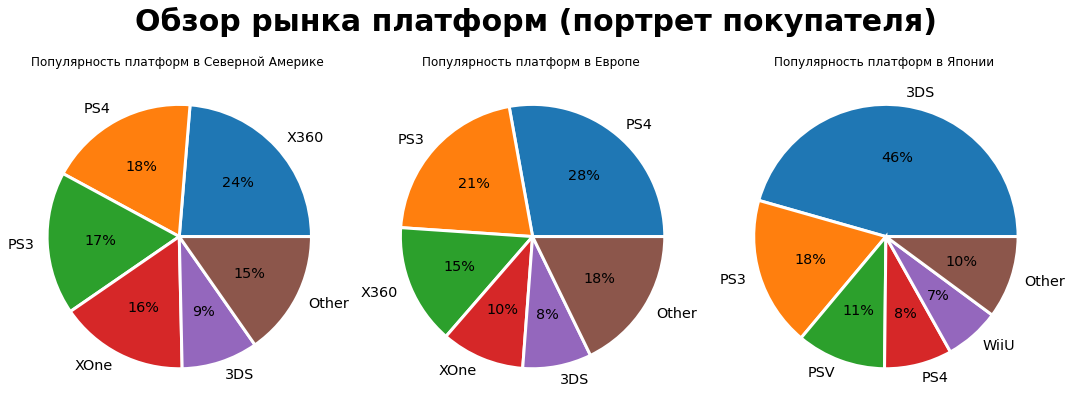

In [106]:
# check
# круги в ряд
fig, axes = plt.subplots(1, 3, figsize = (15,6))
fig.suptitle('Обзор рынка платформ (портрет покупателя)', fontsize = 30, fontweight='bold')

x_year = 2012

graph(data_games, x_year, 'na_sales', 'Северной Америке', axes[0])
graph(data_games, x_year,'eu_sales', 'Европе', axes[1])
graph(data_games, x_year, 'jp_sales', 'Японии', axes[2])

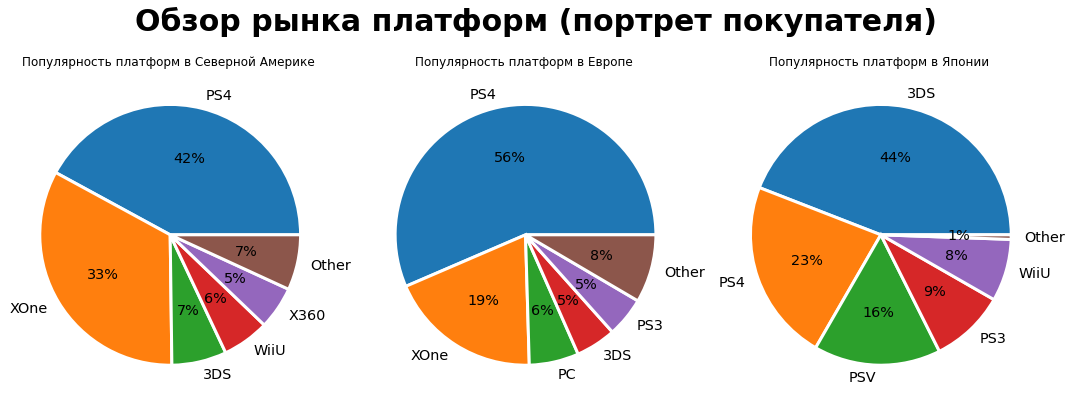

In [107]:
# check
# круги в ряд
fig, axes = plt.subplots(1, 3, figsize = (15,6))
fig.suptitle('Обзор рынка платформ (портрет покупателя)', fontsize = 30, fontweight='bold')

x_year = 2015

graph(data_games, x_year, 'na_sales', 'Северной Америке', axes[0])
graph(data_games, x_year,'eu_sales', 'Европе', axes[1])
graph(data_games, x_year, 'jp_sales', 'Японии', axes[2])